<a href="https://colab.research.google.com/github/a-parida12/furry-octo-spork/blob/main/solution/LungSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting The Playground Ready

Some of the steps to get the colab ready for training

In [54]:
import os
from pathlib import Path
from glob import glob
from collections import defaultdict
import pandas as pd
import re

import matplotlib.pyplot as plt
import cv2

# configure the kaggle downloader api
path_to_json = '/content/kaggle.json'
os.environ['KAGGLE_CONFIG_DIR'] = str(Path(path_to_json).parent)

In [55]:
# Download the dataset from kaggle
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels
# unzip the images 
!unzip \*.zip  && rm *.zip

 10% 0.98G/9.58G [00:07<01:09, 133MB/s]
User cancelled operation
Archive:  chest-xray-masks-and-labels.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of *.zip or
        *.zip.zip, and cannot find chest-xray-masks-and-labels.zip.ZIP, period.

No zipfiles found.


# Loading the Image and Processing it

Targets-

*   Load Image
*   Resize Image
*   Normalise the Image



In [75]:
data_path = "/content/"  # directory where the Lung Segmentation folder is located

# load the image paths and mask paths
lung_image_paths = glob(os.path.join(data_path,"Lung Segmentation/CXR_png/*.png"))
mask_image_paths = glob(os.path.join(data_path,"Lung Segmentation/masks/*.png"))

In [76]:
related_paths = defaultdict(list)

for img_path in lung_image_paths:
    img_match = re.search("CXR_png/(.*)\.png$", img_path)
    if img_match:
        img_name = img_match.group(1)
    for mask_path in mask_image_paths:
        mask_match = re.search(img_name, mask_path)
        if mask_match:
            related_paths["image_path"].append(img_path)
            related_paths["mask_path"].append(mask_path)

paths_df = pd.DataFrame.from_dict(related_paths)

In [77]:
# lets see how the image-mask pairing looks like
print(paths_df.head())

                                          image_path                                          mask_path
0  /content/Lung Segmentation/CXR_png/CHNCXR_0469...  /content/Lung Segmentation/masks/CHNCXR_0469_1...
1  /content/Lung Segmentation/CXR_png/MCUCXR_0387...  /content/Lung Segmentation/masks/MCUCXR_0387_1...
2  /content/Lung Segmentation/CXR_png/CHNCXR_0384...  /content/Lung Segmentation/masks/CHNCXR_0384_1...
3  /content/Lung Segmentation/CXR_png/CHNCXR_0528...  /content/Lung Segmentation/masks/CHNCXR_0528_1...
4  /content/Lung Segmentation/CXR_png/CHNCXR_0307...  /content/Lung Segmentation/masks/CHNCXR_0307_0...


In [59]:
x_train=[]
y_train=[]
# process the data to make it train ready
for i in range (len(paths_df)):
    xray_num = i
    img_path = paths_df["image_path"][xray_num]
    mask_path = paths_df["mask_path"][xray_num]

    # read the 3 channel image and resize it to (256, 256, 3)
    img = cv2.imread(img_path)
    img = cv2.resize(img,(256,256))
    
    # bring the img from [0,255] -> [0,1]
    assert img.shape == (256, 256, 3)
    img = img/255
    
    # read the single channel mask and resize it to (256, 256)
    mask = cv2.imread(mask_path)
    mask = cv2.resize(mask,(256,256))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    # bring the mask from [0,255] -> [0,1]
    assert mask.shape == (256, 256)
    mask= mask/255

    x_train.append(img)
    y_train.append(mask)
print (f"Image {i} added")

Image 703 added


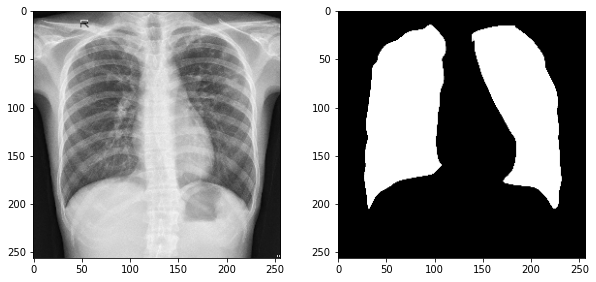

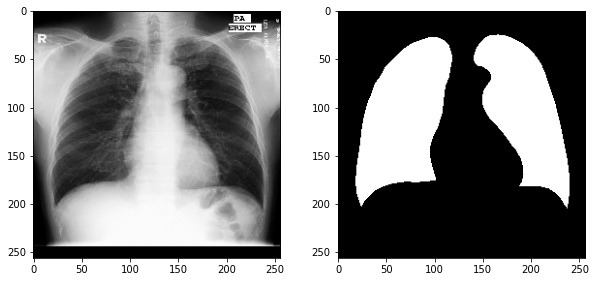

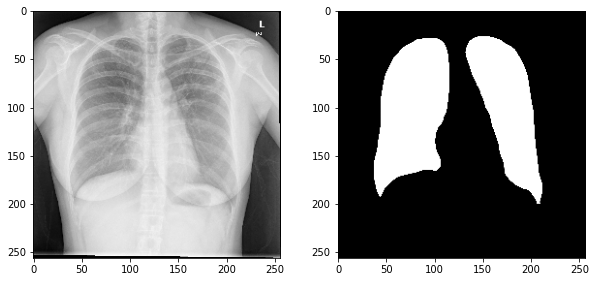

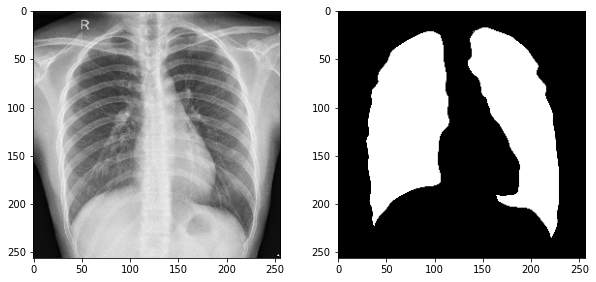

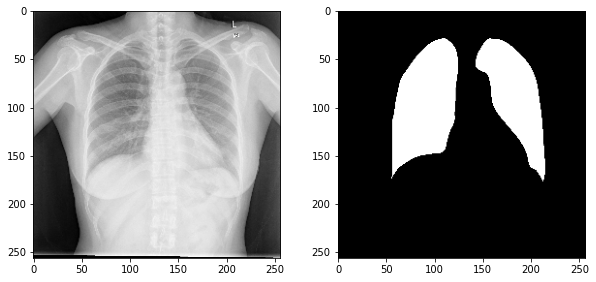

In [60]:
# let us see some image-mask pairing
for i in range (5):


    fig = plt.figure(figsize = (10,10))
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(x_train[i], cmap = "gray")
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(y_train[i], cmap = "gray")

In [61]:
input_shape = (256, 256, 3)

## Deep Learning Begins Here

Target-


*   Build a Model
*   Select some Hyperparameters
*   Train a Model
*   Save a Trained Model



In [62]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import * 
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

In [63]:
# split the dataset into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)


In [64]:
# defination of the deep learning based segmentor
def Segmenter(input_size=(256, 256, 1), latent_dim = 8):
    # Input Layer
    input_img = Input(shape=input_shape, name='encoder_input')
    
    # Encoder 
    x = Conv2D(16, (3, 3), padding='same', activation='relu')(input_img)
    x = Conv2D(32, (3, 3), padding='same', activation='relu',strides=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    conv_shape = K.int_shape(x) 
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)

    # Latent Space
    z = Dense(latent_dim, name='latent_vector')(x)
    
    # Decoder
    x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(z)
    x = Dropout(0.1)(x)
    x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', activation='relu',strides=(2, 2))(x)
    output = Conv2DTranspose(1, (3, 3), padding='same', activation='sigmoid', name='decoder_output')(x)

    model = Model(inputs = input_img, outputs = output)
    # define the model optimiser, losses and metrics
    model.compile(optimizer = Adam(learning_rate= 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [65]:
# load the model
model = Segmenter(input_shape)
# model layer by layer summary
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
flatten_3 (Flatten)          (None, 2097152)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                6710

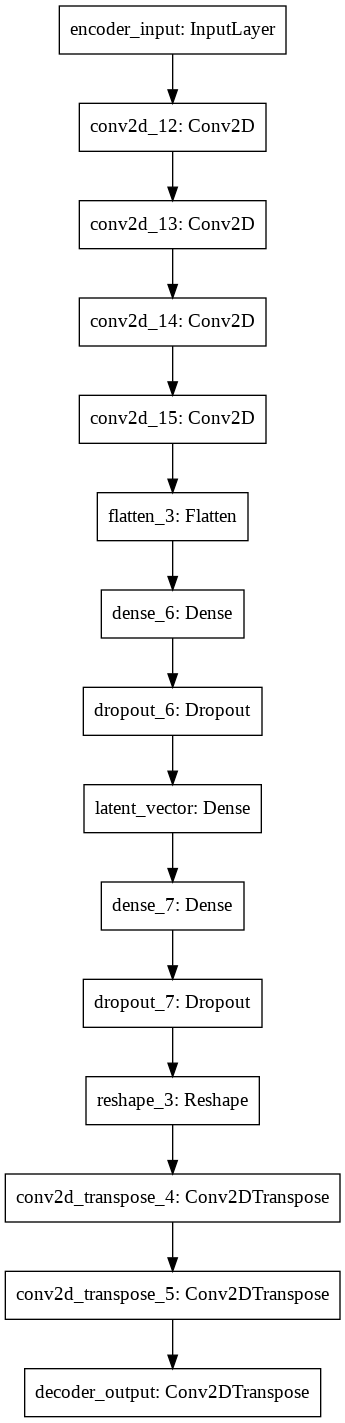

In [66]:
# some more model viz
tf.keras.utils.plot_model(
    model,
    to_file="model.png"
)

In [67]:
# early stopping to prevent overfitting
model_checkpoint = ModelCheckpoint("/content/trained_model.h5", monitor='loss',verbose=2, save_best_only=True)

# tain the model
history = model.fit(x = np.array(x_train), 
                    y = np.array(y_train), 
                    epochs = 200, 
                    batch_size = 32,
                    validation_data=(np.array(x_val), np.array(y_val)),
                    callbacks = [model_checkpoint])

Epoch 1/200
18/18 [==============================] - 23s 1s/step - loss: 0.5847 - accuracy: 0.7543 - val_loss: 0.3333 - val_accuracy: 0.8538

Epoch 00001: loss improved from inf to 0.58468, saving model to /content/trained_model.h5
Epoch 2/200
18/18 [==============================] - 19s 1s/step - loss: 0.2821 - accuracy: 0.8815 - val_loss: 0.2346 - val_accuracy: 0.8952

Epoch 00002: loss improved from 0.58468 to 0.28210, saving model to /content/trained_model.h5
Epoch 3/200
18/18 [==============================] - 19s 1s/step - loss: 0.2422 - accuracy: 0.8927 - val_loss: 0.2277 - val_accuracy: 0.8967

Epoch 00003: loss improved from 0.28210 to 0.24216, saving model to /content/trained_model.h5
Epoch 4/200
18/18 [==============================] - 19s 1s/step - loss: 0.2400 - accuracy: 0.8935 - val_loss: 0.2287 - val_accuracy: 0.8969

Epoch 00004: loss improved from 0.24216 to 0.23998, saving model to /content/trained_model.h5
Epoch 5/200
18/18 [==============================] - 19s 1s/

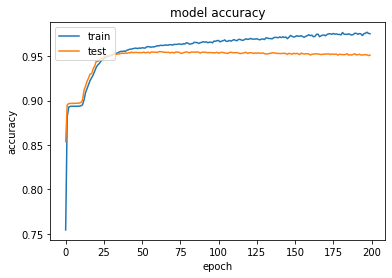

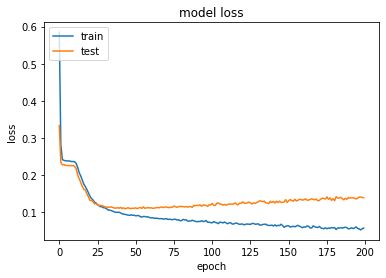

In [68]:
# lets take a look how model training went

# plot training vs validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# plot training vs validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [69]:
# let us save the trained model
model.save("/content/trained_model.h5")

# Inference



*   Load a trained model
*   Do inference



In [70]:
# loading the model
pretrained_weights_path = "/content/trained_model.h5"
model = Segmenter(input_shape)

# adding weights from the pretrained model
model.load_weights(pretrained_weights_path)

In [71]:
test_path_dir = os.path.join(data_path,"Lung Segmentation/test/")
test_images = os.listdir(os.path.join(data_path,"Lung Segmentation/test/"))

In [72]:
# load the data and do the same preprocessing as the training data
x_test=[]
for i in range (len(test_images)):
    xray_num = i
    test_path = test_path_dir + test_images[xray_num]

    img = cv2.imread(test_path)
    img = cv2.resize(img,(256,256))
    x_test.append(img)
print (f"Image {i} added")

Image 95 added


In [73]:
# inference
x_test= np.array(x_test)
y_pred=model.predict(x_test)

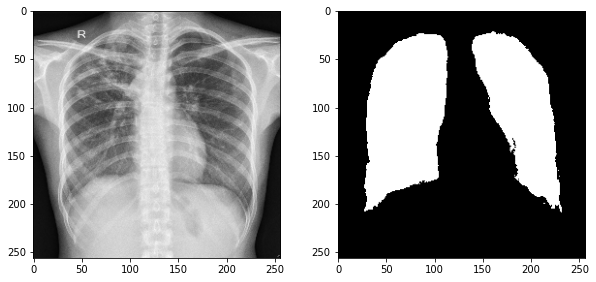

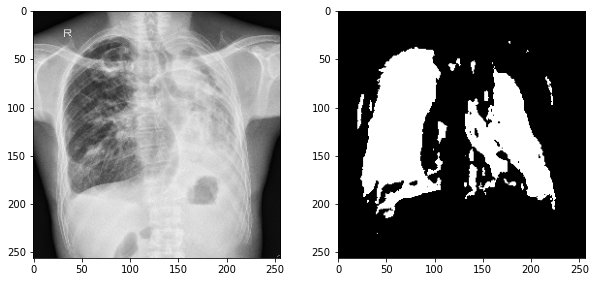

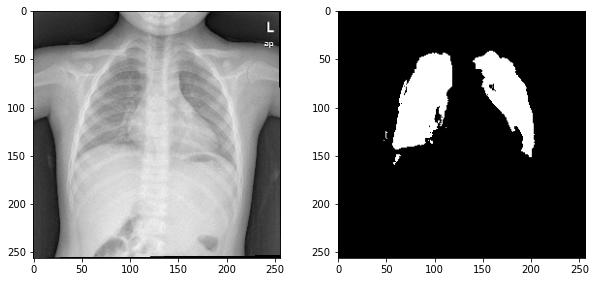

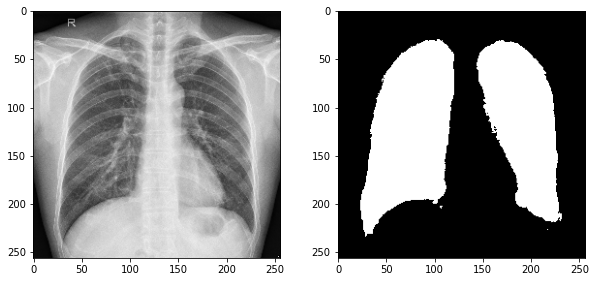

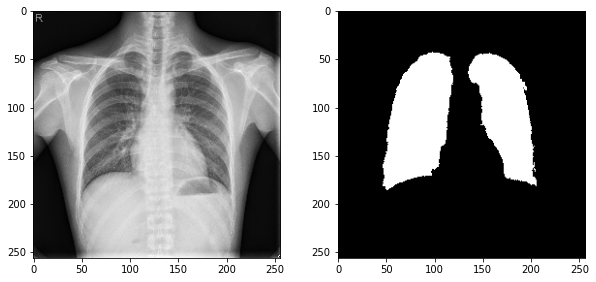

In [81]:
# let us visualise the outputs for the test set
for i in range (5,10):
    fig = plt.figure(figsize = (10,10))

    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(x_test[i], cmap = "gray")
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(np.squeeze(y_pred[i]), cmap = "gray")